# Lab 1: A Ligand-based Virtual Screening Pipeline

Review the lab material and go through the entire notebook. 
The lab contains 5 exercises for you to solve. The entire lab is worth 2.5% of your final grade and each exercise is worth 0.4% of your final grade. Going through the full notebook is worth 0.5% of your final grade.
Any extra credit or bonus exercises are worth an additional 0.4%.

Labs are due within 48 hours and can be submitted by email to the course instructor and TA.

## Motivation of Virtual Screening

Virtual screening (VS) is a computational framework to predict and prioritize compounds as drug candidates by simulating their interactions with a target receptor or predicting other properties relevant to drug discovery, thereby reducing the number of compounds that need to be experimentally tested.

Virtual screening is much faster and cheaper than experimental screening; we can test a magnitude of $10^9$ to $10^{12}$ compounds per day (equivalent to at least ~3 years of experimental screening per day of virtual screening). 

Simulation of molecular dynamics or molecular docking are examples of VS approaches based on first principles of physical processes, such as intermolecular force fields, to discern how the compound or ligand might move around in physical space or reorient its structure to bind with the target.

## Loading a Virtual Screening Library

Run the following code blocks to set up the data for the lab. These will take some time to run so read on in the interim!

We start by setting up installs according to the `requirements.txt` file and importing required modules.

In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import subprocess
import time

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    Descriptors,
    MolFromSmiles,
    PandasTools,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

In [4]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15
dopts.dotsPerAngstrom = 100

In [5]:
from rdkit.Chem import PandasTools

specs = PandasTools.LoadSDF(
  "data/Specs.sdf", smilesName='smiles', molColName=None
)[["PUBCHEM_SUBSTANCE_ID", "smiles"]]

# Note: This may take some time
PandasTools.AddMoleculeColumnToFrame(specs, 'smiles', 'mol')

[21:46:52] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[21:47:24] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 2 ignored.
[21:47:31] Explicit valence for atom # 9 N, 4, is greater than permitted
[21:47:31] ERROR: Could not sanitize molecule ending on line 6498564
[21:47:31] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[21:47:43] Explicit valence for atom # 9 N, 4, is greater than permitted
[21:47:43] ERROR: Could not sanitize molecule ending on line 8305274
[21:47:43] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[21:47:43] Explicit valence for atom # 10 N, 4, is greater than permitted
[21:47:43] ERROR: Could not sanitize molecule ending on line 8315499
[21:47:43] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted
[21:47:50] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 3 ignored.
[21:47:50] Warning: ambiguou

In [6]:
specs.shape

(212670, 3)

## Virtual Screening Taxonomy

Virtual screening pipelines are often hierarchical, proceeding with a broad, large number of compounds through simpler, less restrictive, and computationally cheaper processes to whittle down the quantity of compounds for more complex processes. The simplest filters include compound filters for drug-likeness and known structural alerts. Since lead optimization results in an increase in molecular complexity, filters that assess lead-likeliness or desired ADMET properties may also be applied to discourage compounds that would necessitate too many changes during lead optimization.

After use of chemical compound filters, virtual screening methods are broadly categorized depending on the information we have available about the target and its 3D structure. If we have the target’s 3D structure available, we can perform structure-based methods such as protein-ligand docking. By “3D structures,” we mean that previous experiments (using techniques such as X-ray crystallography or nuclear magnetic resonance spectroscopy) have determined the target’s structure.

If a defined target structure is unavailable, either from a database such as PDB or from our own experiments, then we can still take advantage of ligand-based methods. If we have just one active compound, we can perform a similarity search: screen the active compound against a library of other compounds to identify which compounds are like the active compound. Intuitively, compounds with similar structures or properties to a known active compound have a higher chance of being active. If we have several known, active compounds, then we can also conduct a ligand-based pharmacophore search (in addition to a similarity search). In pharmacophore searching, we take our list of active compounds, generate possible configurations of their 3D shape, and try to align these possible configurations to find common structural features shared by the different active compounds. We can score structural features with high commonality and conduct a search for which of our unknown compounds have high-scoring features.

If we have many known, active compounds as well as known, inactive compounds, then we can enter the realm of machine learning (ML) methods. In ligand-based machine learning, our goal is to train a model that can identify a correlation between the structural features of the compounds in our dataset and how they relate to the compound’s activity. If our model can discriminate between known active and inactive compounds, we hope it’s performance will generalize to new compounds that weren’t in the training dataset. Machine learning models for predicting compound activity are sometimes referred to as quantitative structure-activity relationship (QSAR) models (though not all QSAR models are ML models). Quantitative structure-property relationship (QSPR) is the more general term that refers to quantifying the relationship between structure and any molecular property.

It is also common to use multiple virtual screening methods, one after the other, of increasing complexity. This approach is referred to as hierarchical virtual screening. Each step filters out more structures of no further interest, until at the end of the process a series of candidate structures remain. For example, we can use rule-based compound filters to rapidly screen out the most egregious candidates, followed by ligand-based virtual screening as a more nuanced detector of active compounds. Remaining compounds can then be subject to more rigorous and intensive structure-based methods, e.g., protein-ligand docking or molecular dynamics simulations, with one or more targets of interest.

![UN01](./figures/L01_UN01_Flynn.svg)

We've begun discussing data structures and algorithms to represent molecules, which are also handy for comparing molecules to each other (e.g., similarity) and sorting those molecules based on their similarity to a query structure. Assuming we have one active query compound, let's extend our knowledge to screen the query compound against a library of other compounds to identify which compounds are like the query.

## Scenario: Hit Identification of Antimalarial Compounds

We’ll show how to use ligand-based virtual screening to evaluate compounds for antimalarial potential based on the similarity of their structures to known antimalarial compounds. Malaria is a life-threatening parasitic disease that affects millions of people worldwide, primarily in tropical and subtropical regions. It is a major global health problem, causing a significant number of deaths, particularly among young children and pregnant women. Developing effective antimalarial drugs can directly contribute to reducing malaria’s global health burden and negative economic impact. 
Antimalarial drug research often focuses on various protein targets within Plasmodium falciparum, which is the most common vector of malaria. These protein targets are critical to its survival, replication, and invasion of host cells. An ominous threat to controlling malaria is P. falciparum’s ability to adapt and develop resistance to antimalarial drugs. Drugs that were once effective in treating malaria can become ineffective over time, and new therapeutics are repeatedly necessary.

We will initiate a virtual screening campaign to identify antimalarial drug candidates, evoking recent successes for inspiration. We will begin with a sizable quantity of novel molecules and filter out substances that lack drug-like qualities or have detrimental properties, such as toxicity risk. To initiate the screen, we will start with a diverse range of >212K small molecules made available by PubChem from the SPECS repository, casting a wide net over chemical space. A key feature of SPECS is commercial availability – desirable compounds for downstream experiments are synthesizable and conveniently available for purchase. There are many other commercial vendors offering millions of compounds that meet a variety of characteristics and are purchasable, e.g., ChemBridge, eMolecules, Enamine, Life Chemicals, and Maybridge. 

We will then use a complementary resource, the Malaria Box compounds, containing 400 known actives against P. falciparum. To identify promising hit compounds, we will conduct a similarity search to cross-reference our diverse chemical library against the Malaria Box. In later chapters, we will consider how to optimize and develop discovered hits into potential antimalarial drugs.

## Strategy: Similarity Seaching & Sorting

Similar compounds have similar properties. If we have at least one compound that has a known activity or property of interest, we can use it as a reference point to search for similar compounds that might produce a similar effect. Naively, we could calculate similarity between the reference compound and each compound in our library, order the library compounds by highest similarity, and retain the most similar compounds for experimental validation. 

However, there are three key factors that add complexity to our naïve similarity searching strategy.
1. Representation: How do we represent molecules as meaningful features to a computer? There are different ways we can represent a molecule in terms of features that describe its properties or structure.
2. Similarity Metric: How do we compare similarity between two compounds? There are different metrics that quantify similarity between molecules as a proxy for similar biological function.
3. Search Strategy: If there is one reference, we may only care about the most similar molecule(s). But if there are multiple references, how should we prioritize a molecule based on its aggregate similarity to all available reference compounds? What if we want a search strategy that can accommodate new molecules that we might consider later? Furthermore, molecules can be similar in different ways. How do we factor this into our search? Which features are meaningful for similarity comparison?

Each factor has multiple available options with advantages or disadvantages, and they are linked together. In general, our similarity metric measures the extent of shared features between molecule pairs. Choice of feature representation affects results of using different similarity metrics and search strategies. As an example, the following figure exemplifies the nuances in structure-property relationships that make similarity searching a challenging task.

![UN02](./figures/L01_UN02_Flynn.svg)

### Structure Data Files (SDFs)

We loaded the Specs data set by ingesting it as a Structure Data File (SDF) into a Pandas DataFrame. No need to have familiarity with Pandas, it is just a tool we can use to store the molecules in our dataset.

SDFs are one way we can store multiple molecular structures (both 2D and 3D) along with associated property information. SDFs are derived from the concept of a connection table. The simplest connection table defines enough information to generate a molecule as a graph, where nodes are atoms and edges are bonds. This only requires an atom table and a bond table.

An atom table indexes each atom. A bond table designates the two atoms involved in each bond and the type of bond. Bond orders of 1, 2, and 3 correspond to single bonds, double bonds, and triple bonds, respectively. Hydrogens may be implicitly or explicitly defined. The former is not an issue as algorithms exist that can determine the number of hydrogens. Also note that connection tables are not unique – we could derive a different, but equivalent connection table by swapping the indices of two atoms and their bonds.
To express meaningful chemical information cohesively and explicitly, SDFs extend connection tables to incorporate 2D or 3D spatial information and information associated with individual atoms or bonds and the entire structure. The most common SDF format is based on the MOL file format developed by Molecular Design Limited (MDL), of which the V2000 and V3000 formats are often used.

Information for each SDF entry is compartmentalized into blocks. The bottom-half of the following figure shows an example entry for benzoic acid. The header block’s two lines describe the molecule’s name or formula (C7H6O2), the program used to make it (ChemDraw), the date and time it was made (August 15th, 2023), and if 2D or 3D coordinates are given. The count block tells us there are 9 atoms, 9 bonds, no chirality, and that the file format is V2000. The atom block contains X, Y, Z coordinates of each atom and the atom symbol. The additional columns may encode property information, but a separate properties block is usually used instead. The bonds block designates two atoms by their index (first and second columns) and their bond order (third column) and stereochemistry (fourth column).

![UN03](./figures/L01_UN03_Flynn.svg)

Let's inspect one of the molecules and its type.

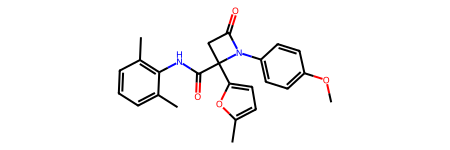

In [7]:
mol = MolFromSmiles(specs.smiles[0])
mol

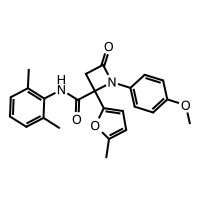

In [8]:
# The following prints out a cleaner version of the above
img = Draw.MolsToGridImage(
  mols=[mol], molsPerRow=1, useSVG=True, drawOptions=dopts,
)
img

In [9]:
type(mol)

rdkit.Chem.rdchem.Mol

### Molecule Sanitization

As the Pandas DataFrame was being processed, you likely noticed a few errors with the form “ERROR: Could not sanitize molecule ending on line 6498564” followed by an explanation of why the SMILES produced the error. These errors are related to sanitization, a preprocessing step that validates whether the SMILES are chemically reasonable before converting it into a Mol. 

Sanitization enforces data quality and reliability to avoid incorrect conclusions, wasted resources, and flawed research outcomes. What constitutes a molecule as valid or not depends on the use case. In virtual screening, we may remove compounds with highly reactive motifs that may manifest as off-target effects or we may remove compounds with bad elements in the context of medicinal chemistry, e.g., compounds with a metal atom. 

At a minimum, we wouldn’t want to retain compounds that aren’t chemically sensible or break fundamental constraints such as valence rules. For most data sets we work with in part one, we will assume compounds are chemically valid if they pass RDKit’s default validation and sanitization. Optionally, RDKit sanitization can be disabled, e.g., mol = Chem.MolFromSmiles(smiles, sanitize=False).


### Structuring the Pipeline

Process:
- Apply compound filters (new topic!)
  - Compute molecular descriptors
  - Property-based Filters
  - Structure-based Filters
- Fingerprinting our Library
- Similarity Searching
- Sorting (Ranking)

## Molecular Descriptors

We want to explore and filter out molecules based on quantifiable properties. We currently have the SMILES column available as a feature. But SMILES are a text string, not a number. The SMILES need to be processed in a way that allows a filter to evaluate it or a model to learn from it. Molecules are complex and how we process them affects a model’s ability to learn from them. There has been a lot of research on how to quantify or featurize molecules, and we will review popular approaches. First, we will compute molecular descriptors that can be used for compound filtering. Later in this chapter, we will compute fingerprint descriptors that can be used for similarity searching.

Molecular descriptors are useful for interpreting a molecule’s properties and for encoding a molecule’s chemical information, so that we can develop a model to predict the properties of other molecules. There are thousands of descriptors that quantify different molecular features and that can be calculated using many different software tools. There are additional, experimentally derived descriptors that can also be accessed, such as databases of empirical molecular constants. Naturally, there is no shortage of documentation on descriptors, including the handbook on molecular descriptors. The below table summarizes the taxonomy of molecular descriptors. RDKit can compute 211 descriptors; let’s dive-in and calculate descriptors on our dataset.


![UN04](./figures/L01_UN04_Flynn.png)

RDKit's `Descriptors` library provides implementations for 211 descriptors. We print out the first 3, which provides both the name of the descriptor and its function call.

In [10]:
from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:3])

211
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x13f397c40>), ('MaxEStateIndex', <function MaxEStateIndex at 0x13f397b00>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x13f397ce0>)]


The following code block shows how we can use RDKit to compute 4 descriptors that describe each molecule’s molecular weight, number of hydrogen bond acceptors (HBAs), number of hydrogen bond donors (HBDs), and logP. 

These descriptors will be useful to define a filter that removes compounds that are not "drug-like? What does it mean to be "dru-like"? Well, given a large library of compounds, we might want some simple rules to characterize them as either drug-like or not drug-like. We could then use our rules for defining drug likeness to filter out compounds that are not drug-like, leaving us to focus on a smaller set of drug-like compounds.
There are multiple guidelines for classifying compounds by their drug-likeness. Perhaps the most common and simple among them is Lipinski’s Rules or Rule of Five, which states that a compound is not drug-like if it violates more than one of the following criteria:

1.	Molecular weight less than 500 daltons
2.	Lipophilicity (calculated logP) of less than 5
3.	No more than 10 hydrogen bond acceptors
4.	No more than 5 hydrogen bond donors

Note that all the rules specify quantity limits that are multiples of five, hence Lipinski’s Rule of Five. Though beneficial for their simplicity, these rules make a crude prediction of a compound’s potential as an oral drug based on properties that affect its bioavailability. Depending on date of analysis, approximately 16% to 20% of orally administered drugs on the market violate this guideline 


In [11]:
RDKIT_DESCRIPTORS = { desc : func for desc, func in Descriptors._descList }
RO5_PROPS = ['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']

def compute_descriptors(mol, func, missing_val=None):
  try:
    return func(mol)
  except:
    return missing_val

for desc in RO5_PROPS:
  specs[desc] = specs["mol"].apply(
    lambda x: compute_descriptors(x, RDKIT_DESCRIPTORS[desc])
  )

specs = specs.dropna(subset=RO5_PROPS)

We can use the `head()` and `describe()` functions to explore what the top 5 rows of the data set look like and to summarize basic statistics of the data set's numerical properties, respectively.

In [12]:
specs.head()

,PUBCHEM_SUBSTANCE_ID,smiles,mol,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
0,469753576,COc1ccc(N2C(=O)CC2(C(=O)Nc2c(C)cccc2C)c2ccc(C)...,<rdkit.Chem.rdchem.Mol object at 0x2a2953ed0>,404.173607,4,1,4.48436
1,469753575,CCOC(=O)c1ccc(NC2SC(=O)N(Cc3ccc(C(=O)OC)cc3)C2...,<rdkit.Chem.rdchem.Mol object at 0x2a2953f40>,428.104207,8,1,3.28350
2,469753574,Cc1cc(Br)cc([N+](=O)[O-])c1N,<rdkit.Chem.rdchem.Mol object at 0x2a2953e60>,229.969090,3,1,2.24792
3,469753573,Oc1ccc(CN2CCN(c3ccccn3)CC2)c2cccnc12,<rdkit.Chem.rdchem.Mol object at 0x2a2953d80>,320.163711,5,1,2.65760
4,469753572,Cc1cccnc1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x2a2953ca0>,136.063663,2,1,0.48892


In [13]:
specs.describe()

,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,212670.000000,212670.000000,212670.000000,212670.000000
mean,371.738321,4.512531,0.990046,3.917192
std,93.585321,1.905391,0.796672,1.587613
min,68.025421,0.000000,0.000000,-4.195200
25%,306.136828,3.000000,0.000000,2.885940
50%,369.020203,4.000000,1.000000,3.855710
75%,432.133005,6.000000,1.000000,4.923815
max,1161.548016,21.000000,8.000000,15.329400


## Compound Filters

Filtering out compounds is a low-cost, scalable maneuver to cut the fat from a large screening library and save downstream effort and resources. We can think of compound filters across two dimensions: property-based filters that consider the values of the descriptors we calculated in the previous section and substructure-based filters that consider the type and frequency of the substructures that we can decompose our molecules into. 

### Property-based Filters

A convenient property-based filter is Lipinski’s Rule of Five (Ro5) as a starting point for evaluating drug-likeness. Assessing a compound’s adherence to Ro5’s four simple criteria measures prospect of oral bioavailability. Molecules that violate Ro5 criteria are likely to constitute poor solubility and permeability characteristics that hinder the effectiveness of oral drugs. 

In [14]:
def lipinski_filter(row):
    """
    Apply Lipinski's Rule of Five to filter molecules.
    Returns True if the molecule violates no more than one rule.
    """
    violations = 0
    # Check each rule
    if row[3] > 500: violations += 1
    if row[6] > 5: violations += 1
    if row[5] > 5: violations += 1
    if row[4] > 10: violations += 1

    # Return True if no more than one rule is violated
    return violations <= 1

In [15]:
specs["ro5_compliant"] = specs.apply(lipinski_filter, axis=1)
specs_ro5_compliant = specs[specs["ro5_compliant"]]
specs_ro5_violated = specs[~specs["ro5_compliant"]]


After applying the R05 filter, we've reduced the compound library from 212,670 compounds to 199,481 "drug-like" compounds.

In [16]:
print(f"Compound library size pre-RO5 filter: {len(specs)}")
print(f"Compound library size post-RO5 filter: {len(specs_ro5_compliant)}")


Compound library size pre-RO5 filter: 212670
Compound library size post-RO5 filter: 199481


Notice also that the distribution of the descriptors has changed. For example, high molecular weight compounds have been filtered out.

In [17]:
specs_ro5_compliant.describe()

,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,199481.000000,199481.000000,199481.000000,199481.000000
mean,359.359352,4.398524,0.994050,3.745281
std,81.695399,1.827768,0.795352,1.448762
min,68.025421,0.000000,0.000000,-3.679400
25%,302.036128,3.000000,0.000000,2.818100
50%,361.142641,4.000000,1.000000,3.744100
75%,419.067284,6.000000,1.000000,4.697100
max,758.331564,18.000000,8.000000,10.683600


![UN05](./figures/L01_UN05_Flynn.png)

The other 3 descriptors are within closer numerical ranges to each other, so we visualize their changes in one lollipop plot comparing the average values for number of HBAs, logP, and number of HBDs.

In [18]:
ro5_avgs_df = pd.DataFrame(data = {
    'property' : ['NumHAcceptors', 'NumHDonors', 'MolLogP'],
    'RO5 Compliant Mols' : [specs_ro5_compliant['NumHAcceptors'].mean(), specs_ro5_compliant['NumHDonors'].mean(), specs_ro5_compliant['MolLogP'].mean()],
    'RO5 Violated Mols' : [specs_ro5_violated['NumHAcceptors'].mean(), specs_ro5_violated['NumHDonors'].mean(), specs_ro5_violated['MolLogP'].mean()]
})

In [19]:
ro5_avgs_df['rel_change'] = (ro5_avgs_df['RO5 Compliant Mols'] - ro5_avgs_df['RO5 Violated Mols']) / ro5_avgs_df['RO5 Violated Mols']
ordered_df = ro5_avgs_df.sort_values(by='RO5 Compliant Mols')
my_range = range(1, len(ordered_df.index) + 1)

![UN06](./figures/L01_UN06_Flynn.png)

### Structure-based Filters

Substructure-based filters are another tool for early elimination of compounds that are unlikely to meet desired criteria. Displeasing substructures interfere with experimental assays or have undesirable properties (e.g., are toxic).

#### Pan Assay Interference Compounds (PAINS)

Promiscuous bioactive compounds, or PAINS compounds, appear active in many high-throughput screening experiments against a broad, diverse range of targets. PAINS are often false positive hits and mislead results in biological assays, producing artifacts in the data. These “frequent hitters” exhibit a propensity to bind to multiple targets due to nonspecific binding or interference with the specific assay technology readouts. PAINS filters are composed of substructures that are associated with PAINS. Conveniently, RDKit maintains pre-defined PAINS filters we can easily use to filter our compound library.

#### Structural Alerts for Toxicity

Broadly, structural alerts refer to any filter based on a molecule’s structural composition. In this context, we will assemble a set of structural alerts that have a known association with toxic endpoints. For example, thiophene, epoxides, and acid anhydrides are common structural alerts used to identify risk of hepatotoxicity, mutagenicity, or skin sensitization, respectively. If a compound contains several structural alerts greater than a user-defined threshold, it is filtered out.

Cross-referencing compounds to a list of structural alerts is a widely used, simple method for identifying problematic compounds. However, structural alerts have limited prognostic utility – they are not sufficient to declare a molecule as toxic and they can misclassify toxic molecules as safe. Since structural alerts are determined retrospectively, they have limited predictive power for new or understudied substructures. 

![UN07](./figures/L01_UN07_Flynn.svg)

In addition to PAINS filters, we’ll also use BRENK filters, which were constructed to remove undesirable substructures that pose toxicity risks within the context of drug discovery for neglected diseases 

In [20]:
from rdkit.Chem import FilterCatalog
filter_params = FilterCatalog.FilterCatalogParams()
filter_params.AddCatalog(filter_params.FilterCatalogs.PAINS)
filter_params.AddCatalog(filter_params.FilterCatalogs.BRENK)
catalog = FilterCatalog.FilterCatalog(filter_params)

In [21]:
specs_ro5_compliant["PAINS_BRENK_compliant"] = specs_ro5_compliant['mol'].apply(catalog.HasMatch)

/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/2468989558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_ro5_compliant["PAINS_BRENK_compliant"] = specs_ro5_compliant['mol'].apply(catalog.HasMatch)


In [22]:
specs_ro5_pains_brenk_compliant = specs_ro5_compliant[specs_ro5_compliant["PAINS_BRENK_compliant"]]

After successive application of the RO5, PAINS, and BRENK filters, we're down to 93,915 compounds. That is less than half of our starting compound library size!

In [23]:
print(f"SPECS compounds compliant with RO5, PAINS, and BRENK: {specs_ro5_compliant['PAINS_BRENK_compliant'].sum()}")

SPECS compounds compliant with RO5, PAINS, and BRENK: 93915


### Exercise 1: Compound Filters

In the code walkthrough, we used BRENK and PAINS filters from the RDKit catalog. Pick another filter from the RDKit catalog and apply it to the compound library (`specs_ro5_compliant`) instead of the BRENK and PAINS filters. What type of structures or properties does the filter you chose assess? How many compounds remain after applying the filter? Was it a more liberal or conservative filter than the ones we used?

### Student Solution to Exercise 1

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [24]:
# TODO: Student to provide solution below


from rdkit.Chem import FilterCatalog
filter_params = FilterCatalog.FilterCatalogParams()
filter_params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.NIH)  
catalog = FilterCatalog.FilterCatalog(filter_params)


specs_ro5_compliant["NIH_compliant"] = specs_ro5_compliant['mol'].apply(lambda mol: not catalog.HasMatch(mol))

specs_ro5_nih_compliant = specs_ro5_compliant[specs_ro5_compliant["NIH_compliant"]]

print(f"SPECS compounds compliant with RO5, BRENK, PAINS, and NIH: {specs_ro5_compliant['NIH_compliant'].sum()}")



/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/1574307446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_ro5_compliant["NIH_compliant"] = specs_ro5_compliant['mol'].apply(lambda mol: not catalog.HasMatch(mol))


SPECS compounds compliant with RO5, BRENK, PAINS, and NIH: 188355


ANSWER TO EXCERCISE 1: 
NIH is a filter that defines a list of functional groups with undesirable properties that can be toxic and reactive. It then splits separates them from the Medicinal functionalities. 

188355 compound remain from 93915, given that we were able to filter out more than 50% of the compunds filtered before using NIH, we can infer this was a more liberal approach.


#### Rapid Elimination of Swill (REOS)

REOS quickly filters out low quality compounds, i.e., “swill”, that are unlikely to be viable drug candidates. REOS improves screening efficiency by avoiding pursuit of unproductive compounds with high likelihood of causing assay artifacts or false positives. RDKit does not have a pre-defined filter for the for REOS, as REOS is more of a concept than a specific ruleset. For example, PAINS is a specific ruleset that embodies REOS’ goal. But that does not block us from defining and using a custom substructure filter with RDKit’s HasSubstructMatch() function.

As an example, let’s load a set of publicly available structure alerts that define the Glaxo Wellcome hard filters. This filter is conveniently encoded as SMARTS. SMARTS are an extension of SMILES that represent specific substructural patterns. We will use SMARTS to search for substructures that might be within each molecule in our library, like regular expressions adapted to chemical compounds. We recommend Daylight’s reference page for a more information: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html

In [25]:
from rdkit.Chem import Draw, MolFromSmarts
glaxo_alerts = pd.read_csv("data/glaxo_structural_alerts.csv")
glaxo_alerts["ROMol"] = glaxo_alerts.smarts.apply(MolFromSmarts)
print(f"Number of Glaxo Wellcome structural alerts: {len(glaxo_alerts)}")

Number of Glaxo Wellcome structural alerts: 55


We visualize examples of 6 substructures within the set of Glaxo Wellcome hard filters. Compounds in our library that have these substructures will be filtered out.

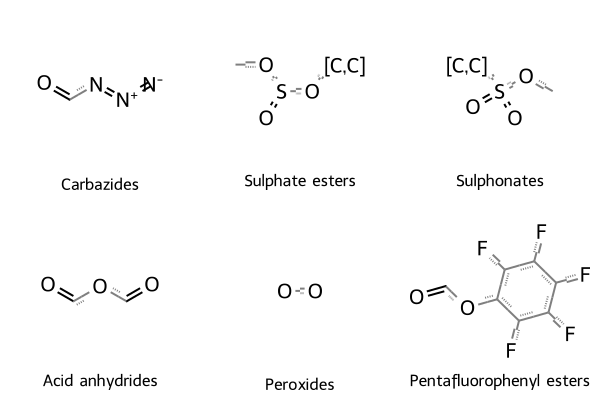

In [26]:
img = Draw.MolsToGridImage(
  mols=glaxo_alerts["ROMol"].iloc[2:8].tolist(), molsPerRow=3, legends=glaxo_alerts["description"].iloc[2:8].tolist(), useSVG=True, drawOptions=dopts,
)
img

Applying the Glaxo Wellcome hard filter sifts out another chunk of molecules, leaving us with 61,372 compounds.

In [27]:
glaxo_sa_matches = []
def glaxo_filter(mol, alerts):
  match_ = False
  for _, alert in alerts.iterrows():
    if mol.HasSubstructMatch(alert.ROMol):
      glaxo_sa_matches.append({
        "mol": mol,
        "alert": alert.ROMol,
        "description": alert.description,
      })
      match_ = True
  return match_

specs_ro5_pains_brenk_compliant["GLAXO_compliant"] = ~specs_ro5_pains_brenk_compliant['mol'].apply(glaxo_filter, alerts=glaxo_alerts)
specs_filtered = specs_ro5_pains_brenk_compliant[specs_ro5_pains_brenk_compliant["GLAXO_compliant"]]
glaxo_sa_matches = pd.DataFrame(glaxo_sa_matches)
print(f"Compound library size after filtering: {specs_ro5_pains_brenk_compliant['GLAXO_compliant'].sum()}")
glaxo_sa_matches["description"].value_counts()[:5]

/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/1774589771.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_ro5_pains_brenk_compliant["GLAXO_compliant"] = ~specs_ro5_pains_brenk_compliant['mol'].apply(glaxo_filter, alerts=glaxo_alerts)


Compound library size after filtering: 78711


acylhydrazide                                10529
Reactive alkyl halides                        1067
Thiols                                        1048
Aliphatic methylene chains 7 or more long      962
Cytochalasin derivatives                       575
Name: description, dtype: int64

We show a few examples of compound matches to the Glaxo Wellcome filter, with the match substructures highlighted in light red.

In [29]:
d2d_hl = Draw.MolDraw2DSVG(-1, -1)
dopts_hl = d2d_hl.drawOptions()
dopts_hl.useBWAtomPalette()
dopts_hl.setHighlightColour((.635,.0,.145,.5))
dopts_hl.baseFontSize = 1.0
dopts_hl.additionalAtomLabelPadding = 0.15

In [30]:
highlights = [mol.GetSubstructMatch(alert) for mol, alert in zip(glaxo_sa_matches.mol, glaxo_sa_matches.alert)]

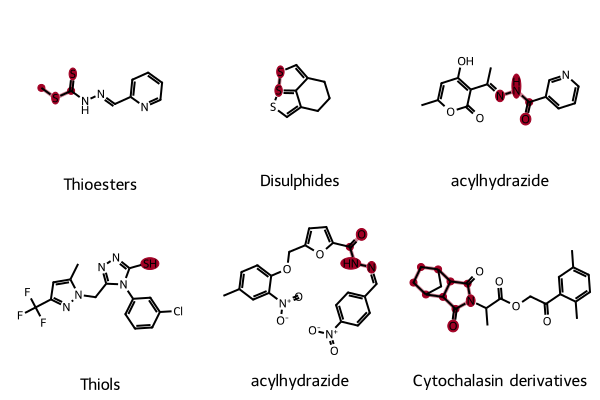

In [31]:
img = Draw.MolsToGridImage(
  glaxo_sa_matches.mol.iloc[2:8].tolist(),
  highlightAtomLists=highlights[2:8],
  molsPerRow=3,
  legends=glaxo_sa_matches.description.iloc[2:8].tolist(),
  drawOptions=dopts_hl,
  useSVG=True
)
img

With just a few simple filters, we’ve reduced our starting library to a third of its original size without losing any molecule’s worth further investigation. Remaining downstream processes will extract greater computational cost, so we’ve reduced noise and improved efficiency of the overall pipeline we are constructing. Let’s move on to the next step, which entails numerically representing our molecules as fingerprints, which we can use to conduct a similarity search and identify promising antimalarial candidates.

## Fingerprints: Representing Molecules as Numbers

### Fingerprint our Library

For our task, we’ll stick with Morgan (circular) fingerprints to generate fingerprint descriptors. Note that, in practice, it is common to try multiple types of fingerprints to assess performance for a given task. To aid in reproducibility, you should always state what fingerprints you used to featurize a molecule and the parameters. We will use a radius of 2 and a fingerprint of length 2048.

Why do we fingerprint our library with a radius of 2 and not 4? We previously described one benefit of radius 4 fingerprints is their ability to capture a larger molecular context, providing a more global perspective on the molecular structure. Features involving atoms that are further apart from each other are more likely to be included. Inversely, a smaller radius of 2 highlights the immediate neighborhood of each atom and is more likely to capture specific functional groups, local arrangements of atoms, or other fine-grained details of molecular structure. Calculating Morgan fingerprints with a smaller radius is computationally cheaper, which is pedagogically beneficial since it is easier to modify the example code and produce new results. In practice, we might try and compare both.

In [32]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

def compute_fingerprint(mol, r, nBits):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    return fp

specs_filtered["morgan_fp_r2_b2048"] = specs_filtered["mol"].apply(compute_fingerprint, r=2, nBits=2048)

/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/1348028656.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["morgan_fp_r2_b2048"] = specs_filtered["mol"].apply(compute_fingerprint, r=2, nBits=2048)


The following code blocks show how we can decompose a molecule and visualize the bits that are set for its corresponding fingerprint. In this example, we only show 5 bits, but the code is easily altered to show all bits for any molecule (this particular molecule has a total of 47 bits set). Notice how none of the fragments cover a path of more than 2-steps away from their central atom, which is highlighted by a blue circle. Yellow circles indicate aromatic atoms; grey circles indicate aliphatic ring atoms. Atoms or bonds that are light grey indicate structures that influence connectivity but are not directly part of the fingerprint. Asterisks indicate extensions beyond the fingerprint itself and can be interpreted as wildcards.

In [33]:
def draw_fragment_from_bit(mol, bit_number):
  """ Given an rdkit mol, draws the local fragment that corresponds to the set bit of ecfp featurization.

  If the bit is not set, will throw an error.
  """
  bi = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
  try:
    svg = Draw.DrawMorganBit(mol, bit_number, bi, useSVG=True)
  except:
    raise ValueError(f"Featurization of mol doesn't have bit {bit_number} set")
  return svg

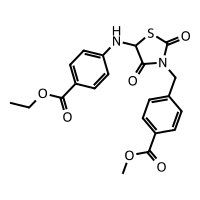

In [34]:
example_mol = specs_filtered.mol.iloc[0]
img = Draw.MolsToGridImage(
  mols=[example_mol], molsPerRow=1, useSVG=True, drawOptions=dopts,
)
img

In [35]:
example_fp = specs_filtered.morgan_fp_r2_b2048.iloc[0]
fp_hit_indices = [idx for idx, bit in enumerate(example_fp) if bit][:5]
example_bits = [draw_fragment_from_bit(example_mol, hit_idx) for hit_idx in fp_hit_indices]

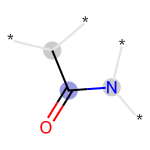

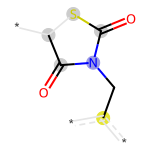

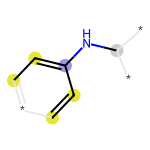

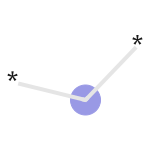

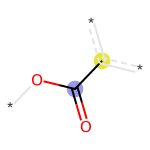

In [36]:
display(*example_bits)

We package this into a nice figure for ease of viewing.

![UN08](./figures/L01_UN08_Flynn.svg)

## Similarity Searching

### Defining "Similarity"

If we take two molecules, we can think of their fingerprints as representing the coordinates of two different data points in a fingerprint feature space. Tanimoto similarity and Dice similarity are two similarity coefficients commonly used to quantify the similarity between sets or binary data, e.g., fingerprints.

Tanimoto similarity (also known as Jaccard similarity) is a measure of similarity between two sets, A and B, and is calculated as the ratio of the size of their intersection to the size of their union. In the context of binary vectors, Tanimoto similarity is calculated as the number of common non-zero elements divided by the total number of non-zero elements in both vectors.

Dice similarity is another measure of similarity between two sets, A and B. It's calculated as twice the size of their intersection divided by the sum of the sizes of the individual sets. For binary vectors, Dice similarity measures the proportion of common non-zero elements relative to the total number of non-zero elements summed across both vectors. 
Mathematically, Tanimoto similarity (T) and Dice similarity (D) are illustrated in the figure below.

Both Tanimoto similarity and Dice similarity range from 0 to 1, where 0 indicates no similarity and 1 indicates complete similarity between the sets or vectors being compared. Note that a similarity of 1 does not indicate that the two molecules are the same. The Daylight manual provides a quick reference to other common similarity measures.

![UN09](./figures/L01_UN09_Flynn.svg)

Before we commence a similarity search across all 400 Malaria Box compounds, we familiarize ourselves with the behavior of Tanimoto and Dice similarities computed between our remaining compound library and a single Malaria Box compound as a query. The following figure shows the extremes – the 3 most similar molecules to the query and the 3 least similar molecules. We can clearly notice a difference in the structures for the 3 most similar molecules and the 3 least similar molecules, where the latter look nothing like the query. In this case, Tanimoto and Dice similarity metrics result in the same molecules at the extremes, though the magnitude of similarity differs. From these few examples, it seems that the Dice coefficient results in higher similarity scores.

In [37]:
malaria_box = pd.read_excel("data/MalariaBox400compoundsDec2014.xls", usecols=["HEOS_COMPOUND_ID", "Smiles"])
PandasTools.AddMoleculeColumnToFrame(malaria_box, 'Smiles', 'mol')
malaria_box["morgan_fp_r2_b2048"] = malaria_box["mol"].apply(compute_fingerprint, r=2, nBits=2048)

query = malaria_box.morgan_fp_r2_b2048.iloc[236]
mols = specs_filtered.morgan_fp_r2_b2048.tolist()

specs_filtered["tanimoto_sim"] = DataStructs.BulkTanimotoSimilarity(query, mols)
specs_filtered["dice_sim"] = DataStructs.BulkDiceSimilarity(query, mols)

/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/2519642692.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["tanimoto_sim"] = DataStructs.BulkTanimotoSimilarity(query, mols)
/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/2519642692.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["dice_sim"] = DataStructs.BulkDiceSimilarity(query, mols)


![UN10](./figures/L01_UN10_Flynn.svg)

### Exercise 2: Fingerprint Similarity Metrics

We computed Tanimoto and Dice similarity coefficients. Pick another similarity coefficient mentioned in the referenced article from the Daylight manual: https://www.daylight.com/dayhtml/doc/theory/theory.finger.html (see section 6.3).

How does your chosen similarity coefficient differ from Tanimoto and Dice similarity? Does it result in similarity scores that tend to be greater or smaller than Tanimoto similarity? You can modify the plotting code below to visualize the relative difference w.r.t. Tanimoto similarity.

### Student Solution to Exercise 2

Provide your solution to the above exercise in this cell and/or immediately following cells.

/var/folders/07/jgsw6xsj6zq4s8dv6xgt6wq40000gn/T/ipykernel_27112/278931457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["cosine_sim"] = DataStructs.BulkCosineSimilarity(query, mols)


<Figure size 640x480 with 0 Axes>

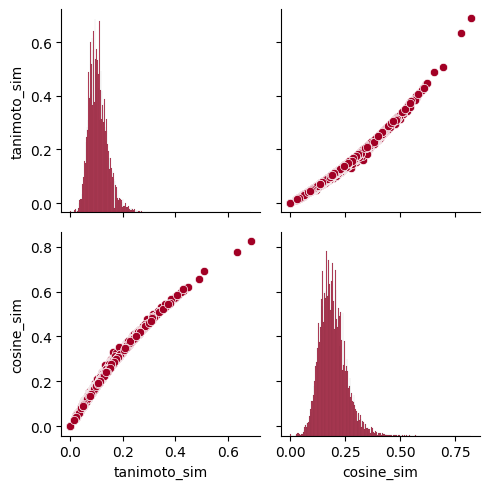

In [40]:



# TODO: Student to provide solution below
malaria_box = pd.read_excel("data/MalariaBox400compoundsDec2014.xls", usecols=["HEOS_COMPOUND_ID", "Smiles"])
PandasTools.AddMoleculeColumnToFrame(malaria_box, 'Smiles', 'mol')
malaria_box["morgan_fp_r2_b2048"] = malaria_box["mol"].apply(compute_fingerprint, r=2, nBits=2048)

query = malaria_box.morgan_fp_r2_b2048.iloc[236]
mols = specs_filtered.morgan_fp_r2_b2048.tolist()
specs_filtered["cosine_sim"] = DataStructs.BulkCosineSimilarity(query, mols)


# Plotting code you can modify and re-use (swap out "dice_sim" for your chosen similarity metric)
plt.figure()
sns.pairplot(specs_filtered[["tanimoto_sim", "cosine_sim"]])
plt.tight_layout()




### Influence of similarity metric on scoring

Choice of a similarity score threshold is dependent on the similarity measure. We can plot the distribution of both Tanimoto and Dice similarity scores against each other to check if this trend generalizes. The below figure shows the relationship is nearly linear and confirms that the Dice similarity score is greater than or equal to Tanimoto similarity score for each molecule in our library. If we were to choose a similarity threshold, e.g., 0.65, we may expect that more molecules will register as hits in our similarity search if we use the Dice similarity metric instead of the Tanimoto similarity metric. 

![UN11](./figures/L01_UN11_Flynn.png)

Beyond dependence on the similarity metric used, similarity search results are also highly dependent on the chosen descriptors or features used to represent each molecule. These factors can cause the search to be too conservative, only returning compounds that are too similar to the reference compound, or too loose such that too many false positive hits are retained. Regarding the former, hits that are so similar that they share common substructures with our reference compounds may not be patentability.

One rule-of-thumb is that a Tanimoto similarity of 0.85 corresponds to equivalent biological activity for drug-like molecules. Depending on context of the overall drug discovery project or the specific biological process being modeled, acceptable thresholds can be lower (e.g., 0.65) or higher (e.g., 0.9) and we recommend consulting related literature for a given problem domain to understand precedence set by prior work. In our case, we’ll count a hit as a molecule in our library that has at least one match against a query with a Dice similarity score of at least 0.65. 

Our similarity search (below) discovered 1,892 suitable molecules based on our similarity criteria. Commonly, we may be limited further by a pre-defined budget of how many molecules we can afford to screen in downstream processes. Let’s suppose we our limited by a budget of 1000 molecules and conduct a brute-force search to retain the top 1000 molecules by similarity score.

In [41]:
from collections import defaultdict
specs_filtered = specs_filtered.reset_index(drop=True)
mols = specs_filtered.morgan_fp_r2_b2048.tolist()
matches = defaultdict(int)

for query in malaria_box.morgan_fp_r2_b2048:
 dice_sim = DataStructs.BulkDiceSimilarity(query, mols)
 matches.update({
    idx : max(sim, matches[idx]) for idx, sim in enumerate(dice_sim) if sim >= 0.65
 })

print(f"Total hits: {len(matches)}")
print(f"Hits per query: {len(matches) / malaria_box.shape[0]}")

Total hits: 1892
Hits per query: 4.73


In [42]:
brute_force_matches = []
budget = 1000
for idx, sim in matches.items():
    if len(brute_force_matches) <= budget:
        brute_force_matches.append((sim, idx))
    else:
        min_tm_idx = len(brute_force_matches)
        min_sim = sim
        for tm_idx, (sim2, idx2) in enumerate(brute_force_matches):
            if sim2 < min_sim:
                min_sim = sim2
                min_tm_idx = tm_idx
        if min_tm_idx < len(brute_force_matches):
            brute_force_matches[min_tm_idx] = (sim, idx)

In [43]:
top_matches = [idx for sim, idx in brute_force_matches]
top_matches

[7203,
 72031,
 8749,
 25542,
 25591,
 26118,
 26129,
 26149,
 26150,
 26841,
 55819,
 27234,
 27344,
 32356,
 27655,
 29343,
 29350,
 39056,
 63423,
 10362,
 57010,
 67649,
 32320,
 32321,
 32322,
 32323,
 32324,
 32452,
 32523,
 32563,
 38001,
 39152,
 47427,
 60954,
 61003,
 61004,
 61005,
 61006,
 61007,
 61008,
 4206,
 67810,
 55116,
 70498,
 76333,
 76334,
 7910,
 73392,
 73393,
 73395,
 73396,
 73397,
 69360,
 25997,
 25999,
 26096,
 26099,
 10279,
 57396,
 27067,
 55095,
 10418,
 27663,
 27687,
 27807,
 50841,
 29277,
 10321,
 57397,
 29507,
 32403,
 37971,
 37972,
 37974,
 37975,
 8746,
 57398,
 29711,
 37994,
 37995,
 37996,
 8748,
 39088,
 55097,
 53181,
 70362,
 29372,
 54842,
 70102,
 70262,
 70265,
 10225,
 70269,
 70270,
 57399,
 70280,
 64614,
 32357,
 40654,
 54673,
 54674,
 54675,
 57400,
 57666,
 5013,
 10586,
 18031,
 1812,
 57401,
 11909,
 57408,
 18547,
 37641,
 23683,
 47962,
 58287,
 57409,
 74519,
 70945,
 29344,
 40232,
 10987,
 73772,
 9635,
 52716,
 57410,
 

To save our top hits, we can run the following code blocks.

In [44]:
specs_hits_to_malaria_box = specs_filtered.filter(items=top_matches, axis=0)

In [45]:
specs_hits_to_malaria_box.to_csv("specs_hits_to_malaria_box.csv", columns=["PUBCHEM_SUBSTANCE_ID", "smiles"], index=False)

### Exercise 3: Being an Intrepid Programmer!

The brute-force implementation is really slow when the number of entries in `matches` greatly exceeds the `budget`. It is also prohibitively memory-intensive if our `budget` is large.

Many programmers have had to deal with similar problems, and have developed methods or libraries to deal with their problems. We can take advantage of this be exploring well-known libraries available in our programming language's ecosystem. To improve our implementation, we can use the `heapq` library: https://docs.python.org/3/library/heapq.html

1. Summarize what the heapq library accomplishes. What are 3 methods available in the library? What are the performance considerations (e.g., Big Oh) of these methods? Take an example code segment from the documentation page and explain what it is doing. 
2. Use `heapq` as an alternative method to sample the top 1000 hits.
3. Compare runtime complexity and memory complexity of the brute-force implementation and your `heapq` implementation.
4. Are the top 1000 compounds of your implementation the same as the top 1000 compounds from the brute-force implementation?

### Student Solution to Exercise 3

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [62]:


#1. The heapq library provide implementation of the heap queue algroithm. It also summarizes the purpose of heap, 
# stating that it is a specialized tree-base data structure that satisfies the heap invariant. This library differs 
# from the text heap since it uses zero-based indexing which is more suitable for Python. It also uses the pop method 
# to return the smalles item not the larges. 
#          3 Methods available in the library: 
#               -  heapq.heapop(heap): Pop and return the smallest item from the heap, maintaining the heap invariant. 
#                  If the heap is empty, IndexError is raised. To access the smallest item without popping it, use heap[0].
#                       Performance: O(log n)
#               -  heapq.heappush (heap, item): Push the value item onto the heap, maintaing the invariant
#                       Performance: O(log n)
#               -  heapq.heapify(x): Transform list x into a heap, in-place, in linear time.
#                       Performance: O(n)

#def heapsort(iterable):
#    h = []                 -- Initializes the empty heap
#   for value in iterable:      --  Push is each value in the for loop heap maintaing the invariant
#        heappush(h, value)
#   return [heappop(h) for i in range(len(h))] --pops/returns all the values from the heap starting with the smallest first.

#heapsort([1, 3, 5, 7, 9, 2, 4, 6, 8, 0])  -- implemented from pushing the values into the heap and popping off the smallest (see above). 





In [64]:
#2. Use `heapq` as an alternative method to sample the top 1000 hits.

import heapq
budget = 1000
top_budget = []
for idx, sim in matches.items():
    if len(top_budget) < budget:
        heapq.heappush(top_budget, (sim, idx))
    else:
        heapq.heappushpop(top_budget, (sim, idx))

top_heap_matches = [idx for sim, idx in top_budget]
top_heap_matches





[37921,
 8704,
 71701,
 18195,
 34580,
 29376,
 75832,
 43458,
 32974,
 65718,
 70518,
 14848,
 37074,
 32341,
 27663,
 57019,
 72038,
 50840,
 50841,
 40400,
 76336,
 3909,
 28645,
 38407,
 27953,
 65221,
 65528,
 64436,
 35966,
 18547,
 18012,
 35529,
 61144,
 54277,
 10441,
 70945,
 67975,
 22930,
 59856,
 28637,
 38982,
 55218,
 72036,
 57471,
 54842,
 11642,
 67981,
 10229,
 23308,
 18027,
 55729,
 62392,
 58988,
 26181,
 61029,
 37641,
 9157,
 58287,
 74519,
 4223,
 27262,
 26880,
 27227,
 7795,
 66788,
 9912,
 73452,
 32562,
 9677,
 3835,
 165,
 6217,
 32507,
 14757,
 10708,
 28634,
 29302,
 74961,
 61855,
 75504,
 32417,
 71887,
 15087,
 31213,
 53181,
 39109,
 61105,
 70813,
 10610,
 63356,
 65076,
 70345,
 6735,
 27343,
 8467,
 15055,
 11884,
 21098,
 17332,
 27424,
 17211,
 62373,
 64065,
 35480,
 26118,
 5545,
 32323,
 64318,
 29361,
 30187,
 6865,
 60545,
 26129,
 15059,
 73319,
 5553,
 67833,
 13009,
 22433,
 69005,
 72059,
 27232,
 18662,
 32508,
 28633,
 35785,
 62300,


In [65]:
#3. Compare runtime complexity and memory complexity of the brute-force implementation and your `heapq` implementation.

#heapq implemetnation is less complex in comparison the the brute-force approach. 
#heapq has a runtme of O(n log k) while Brute - force has O(n k). 
# the memory of both is the same: O(k)

In [53]:

specs_hits_to_malaria_box = specs_filtered.loc[top_heap_matches]


In [54]:
specs_hits_to_malaria_box.to_csv("specs_hits_to_malaria_box.csv", columns=["PUBCHEM_SUBSTANCE_ID", "smiles"], index=False)


In [55]:
top_1000_heap = set(top_heap_matches)



In [56]:
top_1000_bruteforce = set(top_heap_matches) 


In [63]:
# 4. Are the top 1000 compounds of your implementation the same as the top 1000 compounds from the brute-force implementation?
equal = top_1000_heap == top_1000_bruteforce
print(f"Is the top 1000 in brute force equal to heap ? {equal}")


Is the top 1000 in brute force equal to heap ? True


### Bonus Exercise: Quickselect

There is an algorithm, Quickselect, that we can modify to achieve the optimal runtime complexity and space complexity. Explain the Quickselect algorithm, what runtime and space Big Oh complexity we can achieve, and then implement a function that uses Quickselect to sample the top 1000 hits.

### Student Solution to Bonus Exercise

Provide your solution to the above exercise in this cell and/or immediately following cells.

## Retrospective

We only needed at least one known active molecule for antimalarial activity to enable ultra-fast screening via similarity search. However, even with a liberal similarity threshold, we only retained 1892 molecules as hits against the Malaria Box compounds. A starting library of over 212K small molecules seems much smaller once we realize how few hits might result after application of property, substructure, and similarity filters.

Lastly, chemical similarity searching alone is not sufficient – it does not guarantee equivalent biological effect. In particular, activity cliffs refer to minor changes between two molecular structures that are associated with large differences in function. We'll revisit this point later in the course. 

Note: The numbers in the figure below represent a ballpark approximation of the actual amount of remaining compounds from running this lab.

![UN12](./figures/L01_UN12_Flynn.svg)

### Exercise 4: How could we improve?

As we saw in lecture, many problems have overlapping solution sets. Consulting external resources gives us ideas on how to improve. Pick one of the following papers to read and provide a half-page summary on what lessons from the paper could be applicable to our problem.

- Roy, K.K. (2017). Targeting the active sites of malarial proteases for antimalarial drug discovery: approaches, progress and challenges. International Journal of Antimicrobial Agents, 50 (3): 287-302
- Shibeshi, M.A., Kifle, Z.D., & Atnafie, S.A. (2020). Antimalarial Drug Resistance and Novel Targets for Antimalarial Drug Discovery. Infection and drug resistance, 13, 4047–4060. https://doi.org/10.2147/IDR.S279433
- Brenk, R., Schipani, A., James, D., Krasowski, A., Gilbert, I.H., Frearson, J., & Wyatt, P.G. (2008). Lessons learnt from assembling screening libraries for drug discovery for neglected diseases. Chem. Med. Chem., 3 (3): 435–444. https://doi.org/10.1002/cmdc.200700139
- Walters, W.P., Stahl, M.T., Murcko, M.A. (1998). Virtual Screening -- An Overview. Drug Discov. Today. 3: 160–178

### Student Solution to Exercise 4

Provide your solution to the above exercise in this cell and/or immediately following cells.

After completing the trial run and only retaining 1892 molecules as hits against Malaria Box compounds from the 212k small molecules to start, we must consider what properties these molecules provide to make them suitable for use. In the  paper, *Antimalarial Drug Resistance and Novel Targets for Antimalarial Drug Discovery* (2020), Shibeshi et al. discusses the growing issue of drug resistance, driven by factors such as fake drugs, poor-quality antimalarials, and resistance to artemisinin. Based on these insights, we can refine our selection by filtering out molecules that increase the potential for resistance, while favoring those with low solubility in artemisinin, a key antimalarial compound.

Additionally, we can expand our molecular library by exploring other target receptors. We can consider molecules with structures like trioxane and/or endoperoxide bonds, which are characteristics of artemisinin. We should also explore combination therapies, where interacting molecules can enhance target affinity or serve additional functions. For instance, combining properties from antifolates with artemisinin may provide therapeutic advantages since they have different mechanisms of action. However, it is crucial to evaluate any potential toxicity resulting from these interactions, as they could introduce new or unexpected effects.

In practice, we should expand on molecules that demonstrate affinity for multiple key receptors, exhibit multiple combined molecule interactions, and have a reduced likelihood of contributing to resistance. This approach will help refine and optimize our search for effective antimalarial agents.




### Exercise 5: Exploration

Find another compound data set different from the Malaria Box compounds. Describe the data set you chose and its potential applications in two sentences or less.




### Student Solution to Exercise 5

Provide your solution to the above exercise in this cell and/or immediately following cells.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9503559/

The compounds in this data set shows the different FDA drugs and it's multitarget directed ligands, protein–protein interaction network, enzymes, and receptors in relation to treating Alzheimer's disease. This study also use 3D pharmacophores modeling and AI to improve understanding of complex data sets.